## Proximity Learning with CatBoost

This Python code trains a **CatBoost regression model** and computes **instance similarity** based on **proximity learning**. The similarity between two instances is determined by how frequently they appear in the same **leaf node** across trees, with an additional weight based on **tree importance**.

---

## Similarity Computation

We use **Equation (2)** and **Equation (3)** to compute instance similarity.

### Equation (2): Instance Similarity Score

$$
P(i,j) = \frac{1}{N} \sum_{t=1}^{N} \Delta_t \cdot I_t(v(j) = v(i))
$$

where:
- \( N \) is the **total number of trees**.
- \( I_t(v(j) = v(i)) \) is **1 if two instances share a leaf** in tree \( t \), otherwise **0**.
- \( \Delta_t \) is the **importance of tree** \( t \), computed as:

### Equation (3): Tree Importance

$$
\Delta_t = \frac{E(t) - E(t-1)}{\sum_{t=1}^{N} (E(t) - E(t-1))}
$$

where:
- \( E(t) \) is the **error of the model** after tree \( t \).
- The difference \( E(t) - E(t-1) \) measures the **impact of tree \( t \) in reducing error**.

---

## Intuition

- **Instance similarity** is based on **how often instances appear in the same leaf** across trees.
- Trees with **higher importance** (greater error reduction) **contribute more** to the similarity score.
- This approach captures **local relationships** rather than relying on global distance metrics.

This method enhances **interpretability** and **clustering** in machine learning models by leveraging the structure of **gradient boosting decision trees** (GBDTs) like CatBoost.

---

## Step 1: Import Necessary Libraries

In [67]:
import numpy as np
import catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


## Step 2: Loading and Processing Data from AdBench

In [70]:

# List of datasets to use
datasets = ['2_annthyroid', '5_campaign', '39_vertebral']

def load_dataset(dataset):
    path = f'/Users/langatkipkemoivincent/Desktop/ssalad/jupyter/data/{dataset}.npz'
    data = np.load(path, allow_pickle=True)
    return data['X'], data['y']


## Step 3: Defining Function to Train CatBoost and Compute Similarity

In [75]:
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

def compute_similarity(X, y):
    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train a CatBoost Regressor
    model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=0)
    model.fit(X_train, y_train)
    
    # Get leaf indices for each instance
    leaf_indices_train = model.calc_leaf_indexes(X_train)
    
    # Compute errors for tree importance
    train_preds = model.predict(X_train)
    errors = np.square(train_preds - y_train)  # Squared error per instance
    
    tree_errors = [
        mean_squared_error(y_train, np.array(list(model.staged_predict(X_train, ntree_end=i))[-1]))
        for i in range(1, model.tree_count_ + 1)
    ]

    tree_errors = np.array(tree_errors)
    
    # Compute tree importance
    delta_t = np.diff(tree_errors, prepend=0)
    delta_t = np.abs(delta_t)  # Ensure positive values
    delta_t /= np.sum(delta_t)  # Normalize to sum to 1
    
    # Compute similarity scores
    num_trees = model.tree_count_
    similarity_matrix = np.zeros((len(X_train), len(X_train)))
    
    for t in range(num_trees):
        leaf_assignments = leaf_indices_train[:, t]
        for i in range(len(X_train)):
            for j in range(len(X_train)):
                if leaf_assignments[i] == leaf_assignments[j]:
                    similarity_matrix[i, j] += delta_t[t]
    
    similarity_matrix /= num_trees  # Normalize similarity scores
    
    # Ensure all values are positive using Min-Max scaling
    scaler = MinMaxScaler()
    similarity_matrix = scaler.fit_transform(similarity_matrix)
    
    return similarity_matrix, model


## Step 4: Training Model and Computing Similarity for Each Dataset

In [78]:
results = {}
for dataset in datasets:
    print(f'Processing {dataset}...')
    X, y = load_dataset(dataset)
    
    # Sub-sample 1000 instances (or full dataset if smaller)
    sample_size = min(100, len(X))  # Ensure we don't exceed dataset size
    indices = np.random.choice(len(X), sample_size, replace=False)
    X_sample, y_sample = X[indices], y[indices]
    
    # Compute similarity
    similarity_matrix, model = compute_similarity(X_sample, y_sample)
    results[dataset] = {'similarity_matrix': similarity_matrix, 'model': model}

Processing 2_annthyroid...
Processing 5_campaign...
Processing 39_vertebral...


## Step 5: Plotting Similarity Heatmaps

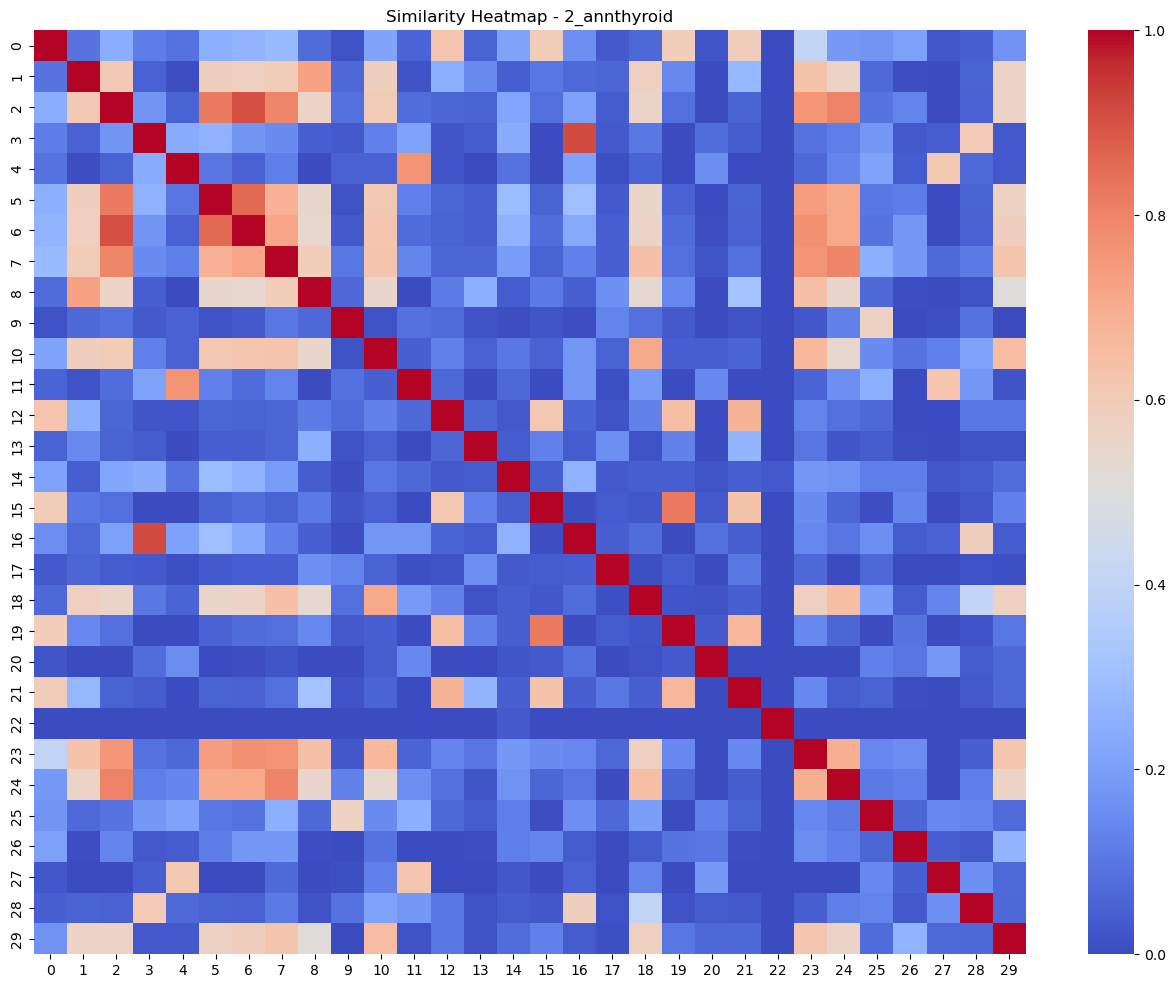

In [109]:
def plot_similarity(similarity_matrix, dataset_name):
    plt.figure(figsize=(16, 12))
    sns.heatmap(similarity_matrix[:30, :30], cmap='coolwarm', annot=False)
    plt.title(f'Similarity Heatmap - {dataset_name}')
    plt.show()

# Plot for one dataset as an example
plot_similarity(results['2_annthyroid']['similarity_matrix'], '2_annthyroid')

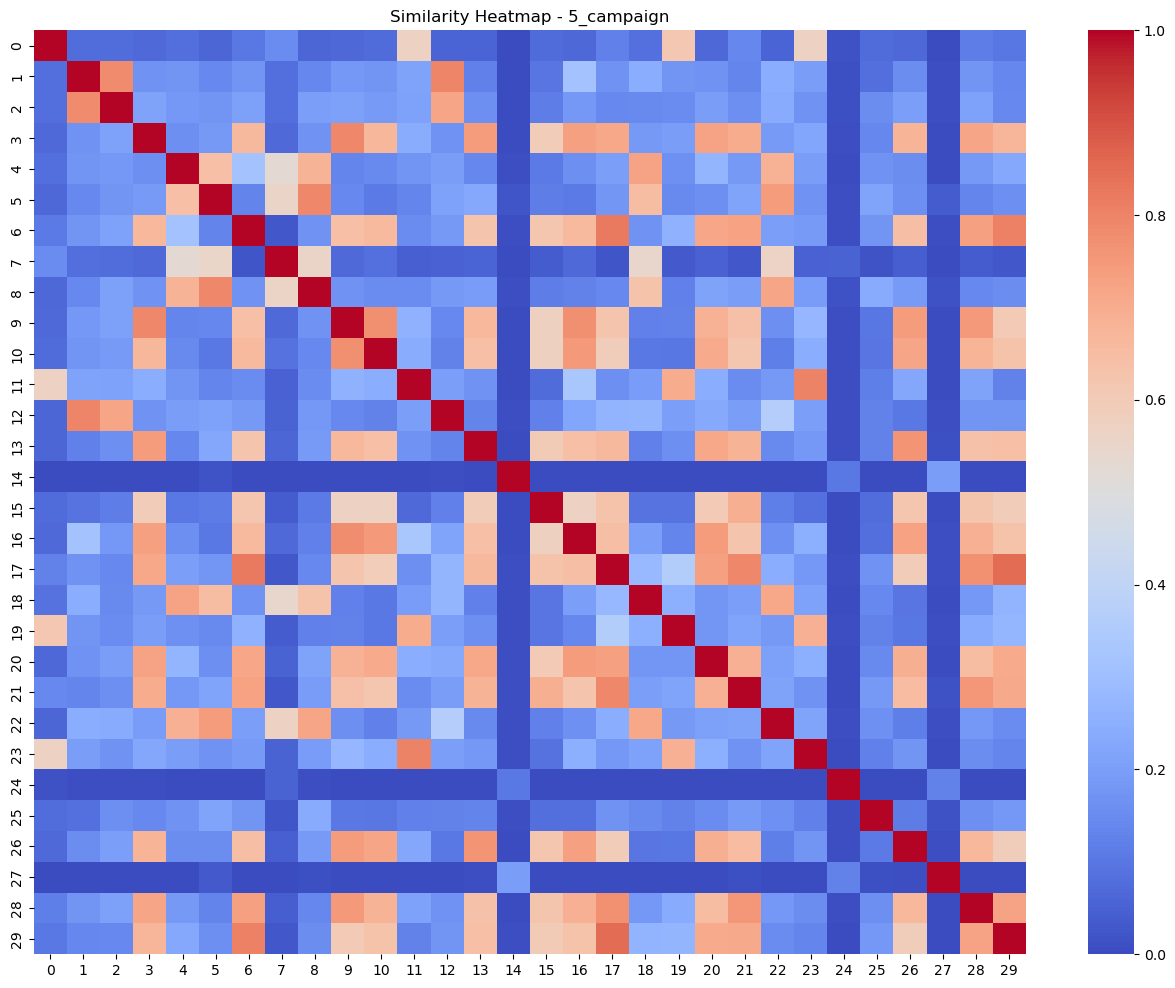

In [111]:
def plot_similarity(similarity_matrix, dataset_name):
    plt.figure(figsize=(16, 12))
    sns.heatmap(similarity_matrix[:30, :30], cmap='coolwarm', annot=False)
    plt.title(f'Similarity Heatmap - {dataset_name}')
    plt.show()

# Plot for one dataset as an example
plot_similarity(results['5_campaign']['similarity_matrix'], '5_campaign')

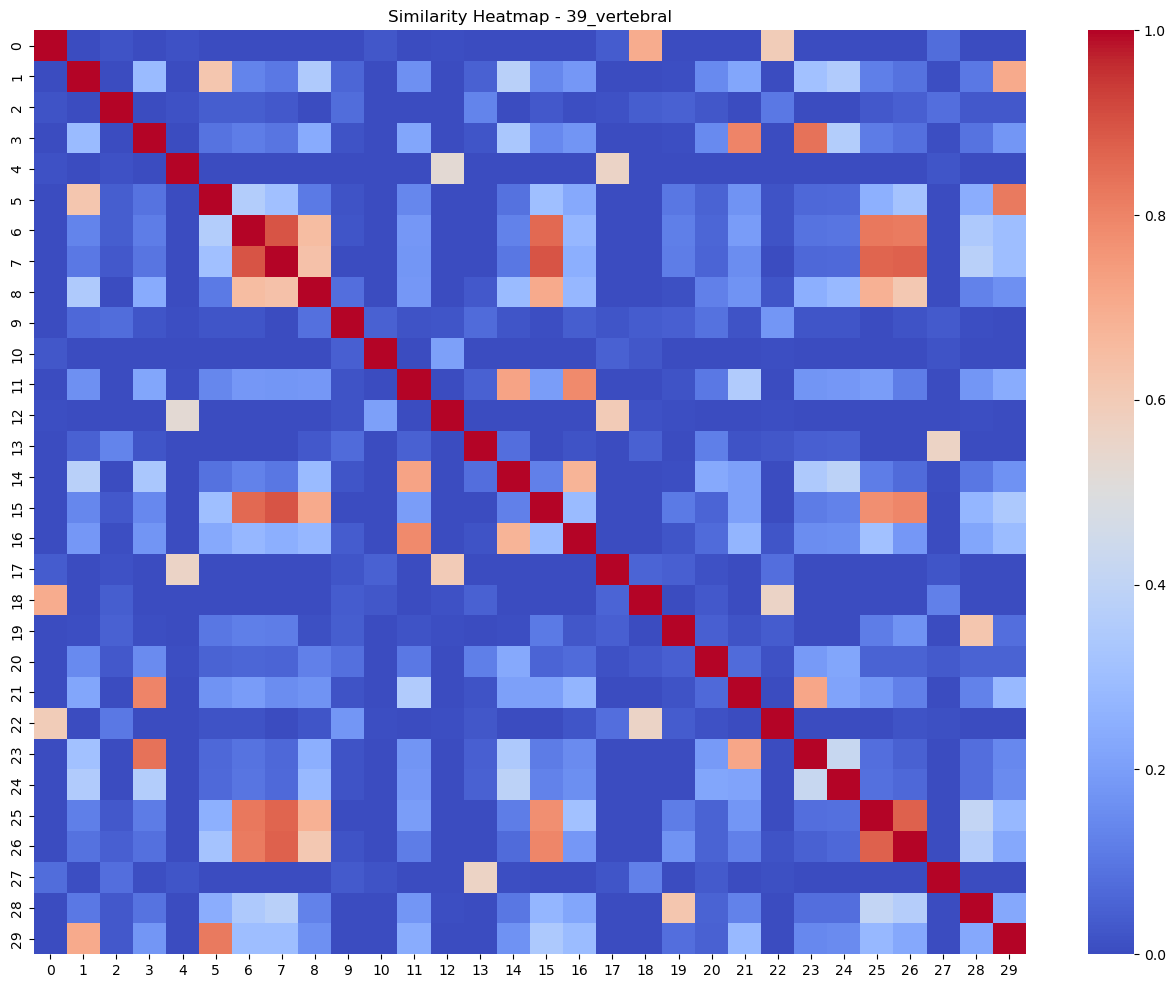

In [112]:
def plot_similarity(similarity_matrix, dataset_name):
    plt.figure(figsize=(16, 12))
    sns.heatmap(similarity_matrix[:30, :30], cmap='coolwarm', annot=False)
    plt.title(f'Similarity Heatmap - {dataset_name}')
    plt.show()

# Plot for one dataset as an example
plot_similarity(results['39_vertebral']['similarity_matrix'], '39_vertebral')

In [83]:
import pandas as pd

def display_similarity_dataframe(dataset_name):
    """
    Display the similarity matrix as a pandas DataFrame.
    """
    if dataset_name not in results:
        print(f"Dataset '{dataset_name}' not found in results.")
        return
    
    similarity_matrix = results[dataset_name]['similarity_matrix']
    
    # Convert NumPy array to Pandas DataFrame
    similarity_df = pd.DataFrame(similarity_matrix)

    print(f"Similarity DataFrame for {dataset_name}:")
    display(similarity_df.iloc[:10, :10])  # Show the first 10 rows and columns

# Example: Display similarity DataFrame for '2_annthyroid'
display_similarity_dataframe('2_annthyroid')


Similarity DataFrame for 2_annthyroid:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.093419,0.245981,0.115551,0.087105,0.250239,0.265227,0.288539,0.070504,0.012409
1,0.093419,1.000000,0.605575,0.048582,0.006996,0.583974,0.579358,0.595577,0.729113,0.065185
2,0.245981,0.605575,1.000000,0.172244,0.053427,0.816665,0.905439,0.794848,0.562997,0.082718
3,0.115551,0.048582,0.172244,1.000000,0.236257,0.258058,0.172224,0.150858,0.044874,0.034660
4,0.087105,0.006996,0.053427,0.236257,1.000000,0.096947,0.048255,0.117803,0.003536,0.047455
5,0.250239,0.583974,0.816665,0.258058,0.096947,1.000000,0.855811,0.686304,0.545201,0.014908
6,0.265227,0.579358,0.905439,0.172224,0.048255,0.855811,1.000000,0.719036,0.541007,0.032707
7,0.288539,0.595577,0.794848,0.150858,0.117803,0.686304,0.719036,1.000000,0.591557,0.099576
8,0.070504,0.729113,0.562997,0.044874,0.003536,0.545201,0.541007,0.591557,1.000000,0.064221
9,0.012409,0.065185,0.082718,0.034660,0.047455,0.014908,0.032707,0.099576,0.064221,1.000000


In [84]:
display_similarity_dataframe('5_campaign')

Similarity DataFrame for 5_campaign:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.077057,0.075701,0.066967,0.078998,0.061348,0.104758,0.150316,0.060917,0.065565
1,0.080204,1.000000,0.783212,0.167398,0.175150,0.142432,0.171990,0.081413,0.139405,0.182455
2,0.078531,0.783136,1.000000,0.212389,0.180282,0.173298,0.206586,0.080698,0.203070,0.204742
3,0.066967,0.164550,0.209970,1.000000,0.156650,0.186773,0.662621,0.067073,0.165152,0.792181
4,0.081818,0.174862,0.180282,0.159231,1.000000,0.641289,0.315414,0.529180,0.682207,0.136177
5,0.065999,0.143762,0.174868,0.190802,0.641970,1.000000,0.132025,0.555468,0.790512,0.142064
6,0.108588,0.172712,0.207555,0.664064,0.316250,0.131435,1.000000,0.026424,0.170437,0.644425
7,0.150316,0.078271,0.077875,0.067073,0.527734,0.553255,0.022241,1.000000,0.558427,0.067694
8,0.065999,0.141135,0.204949,0.169670,0.682957,0.790608,0.171381,0.560817,1.000000,0.168020
9,0.066967,0.180889,0.203497,0.792492,0.134825,0.139086,0.643433,0.069093,0.164748,1.000000


In [85]:
display_similarity_dataframe('39_vertebral')

Similarity DataFrame for 39_vertebral:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.000094,0.019490,0.000000,0.014134,0.000094,0.000088,0.000144,0.000249,0.001636
1,0.000094,1.000000,0.001657,0.285176,0.003055,0.617526,0.131199,0.104698,0.351307,0.061673
2,0.019490,0.001657,1.000000,0.000144,0.012718,0.042793,0.042385,0.027451,0.002667,0.074597
3,0.000000,0.285176,0.000144,1.000000,0.002450,0.090743,0.114974,0.097474,0.236980,0.019055
4,0.014134,0.003055,0.012718,0.002450,1.000000,0.002420,0.002743,0.002797,0.002262,0.003197
5,0.000094,0.617526,0.042793,0.090743,0.002420,1.000000,0.361663,0.305155,0.108114,0.019475
6,0.000416,0.131484,0.042699,0.115264,0.003070,0.361873,1.000000,0.896077,0.649310,0.020345
7,0.000144,0.104698,0.027451,0.097474,0.002797,0.305155,0.896043,1.000000,0.633751,0.002156
8,0.000416,0.351415,0.002834,0.237108,0.002429,0.108264,0.649253,0.633812,1.000000,0.081608
9,0.003319,0.063255,0.076157,0.020709,0.004878,0.021128,0.021676,0.003839,0.083002,1.000000


## Step 6: Save Model and Results

In [87]:
with open('proximity_learning_catboost.pkl', 'wb') as f:
    pickle.dump(results, f)

## Final Thoughts

This method calculates instance similarity using CatBoost trees, where:

- **More co-occurrences in the same leaf** → Higher similarity.  
- **More important trees contribute more to similarity.**  

### This is useful for:  
✅ **Anomaly detection**  
✅ **Clustering similar data points**  
✅ **Feature engineering for recommendation systems**  
